# IBM Streams query sample application

This sample demonstrates creating a Streams Python application to perform a `HTTP GET` query, transform JSON to structured Stream, applying a dynamic filter, and viewing the results.

Familiarity with [Python](https://www.python.org/about/gettingstarted/) is recommended.


In this notebook, you'll see examples of how to :
 1. [Setup a connection to the Streams instance](#setup)
 2. [Create the application](#create)
 3. [Submit the application](#launch)
 4. [Connect to the running application to view data](#view)
 5. [Stop the application](#cancel)

# Overview

**About the sample**

This samples queries location information of public transportation busses in Berlin. The data is retrieved as JSON via `HTTP GET`, tranformed to structured stream and validated.

Furthermore a single bus line or multiple bus lines can be applied to a Dynamic Filter via REST (when job is running). This application creates a REST service that will enable to send data into the Streams application. *(Cloud Pak for Data 3.5+ only)*.

**How it works**
   
A Streams Python application processes a continuous and potentially infinite stream of data. The data is processed in memory and is not stored in a database first.

The Python application created in this notebook is submitted to the IBM Streams service for execution. Once the application is running in the service, you can connect to it from the notebook to continuously retrieve the results.

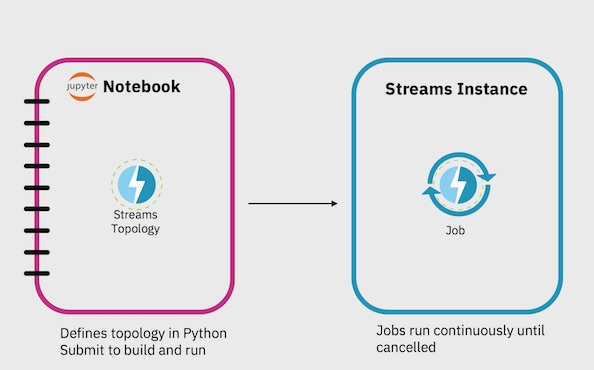



### Documentation

- [Streams Python development guide](https://ibmstreams.github.io/streamsx.documentation/docs/latest/python/)
- [Streams Python API](https://streamsxtopology.readthedocs.io/)




# Prerequisites

This notebook can be used as-is from within an IBM Cloud Pak for Data project. 

If you are not running this notebook from within IBM Cloud Pak for Data, [follow these steps to make sure you have installed all the prerequisites](https://ibmstreams.github.io/streamsx.documentation/docs/python/1.6/python-appapi-devguide-2/).

<a name="setup"></a>

# 1. Set up a connection to the Streams instance


To submit the application for execution, you have to connect to the Streams instance. The information required to connect to the instance depends on your development environment and the target installation of Streams. 

Choose the option that matches your development environment.

- **Option 1**: [I'm running the notebook from an IBM Cloud for Data project](#cpd)
- **Option 2**: [I'm using Jupyter Notebooks, Watson Studio/Cloud Pak for Data as a Service, or any other development environment](#notcpd)


<a name="cpd"></a>
### Option 1: Connect to a Streams instance from an IBM Cloud Pak for Data  project

In order to submit a Streams application you need to provide the name of the Streams instance.

1. From the navigation menu, click **Services > instances**.
2. Update the value of `streams_instance_name` in the cell below according to your Streams instance name
3. Run the cell and skip to section 1.2

The cell below defines a function called `submit_topology` that will be used later on to submit the `Topology` once it is defined.


In [ ]:
from icpd_core import icpd_util
from streamsx.topology import context

streams_instance_name = "" ## Change this to Streams instance

try:
    cfg=icpd_util.get_service_instance_details(name=streams_instance_name, instance_type="streams")
except TypeError:
    cfg=icpd_util.get_service_instance_details(name=streams_instance_name)

def submit_topology(topo):
    global cfg
    # Disable SSL certificate verification if necessary
    cfg[context.ConfigParams.SSL_VERIFY] = False
    # Topology wil be deployed as a distributed app
    contextType = context.ContextTypes.DISTRIBUTED
    return context.submit (contextType, topo, config = cfg)

print("Setup complete, continue to section 1.2")

<a name="notcpd"></a>
### Option 2: Connect to a Streams instance without a Cloud Pak for Data project

*Skip this section if you are running the notebook from a Cloud Pak for Data project.*

The code for each scenario is available in the development guide.  
Each snippet will define a function called `submit_topology` that will be used later to submit the `Topology` once it is defined.

- Choose the tab that best matches your environment. 
- Copy the code under the heading **Copy this code snippet**.
- Paste it in the cell below.

   <a href="https://ibmstreams.github.io/streamsx.documentation/docs/python/1.6/python-appapi-devguide-2/#connect" target="_blank">Connection instructions from the development guide</a>


### 1.2 Import  the `streamsx` package and verify the package version

In [ ]:
import streamsx.topology.context
print("INFO: streamsx package version: " + streamsx.topology.context.__version__)

### 1.3 (Optional) Create application configuration object, used to control the data source stream

Control the source stream

* `start`: Trigger tuple is passed to the Streams operator querying the URL (`HTTP GET`)
* `stop`: Trigger tuple is discarded - **No** `HTTP GET` query is performed

In [ ]:
%%capture --no-display --no-stdout submit_output

def configure_app(cfg, cmd, name='control'):
    from streamsx.rest_primitives import Instance
    cfg[context.ConfigParams.SSL_VERIFY] = False
    instance = Instance.of_service(cfg)
    properties = {}
    if 'stop' in cmd:
        properties['cmd'] = 'stop'
    else:
        properties['cmd'] = 'start'
    # check if application configuration exists
    app_config = instance.get_application_configurations(name=name)
    if app_config:
        print('update application configuration: ' + name)
        app_config[0].update(properties)
    else:
        print('create application configuration: ' + name)
        instance.create_application_configuration(name, properties, 'query-sample')

        

configure_app(cfg, 'stop') # use stop or start as cmd value

<a id="create"></a>
# 2. Create the application
 

All Streams applications start with  a `Topology` object, so start by creating one:


In [ ]:
from streamsx.topology.topology import Topology

topo = Topology(name="QuerySample", namespace="sample")

## 2.1 Define sources
Your application needs some data to analyze, so the first step is to define a data source that produces the data to be analyzed. 

In this sample we align multiple operators (SPL and Python) to generate our source stream containing the **JSON** responses of a `HTTP GET` query.

This section will:

* Create a pulse stream sending a tuple every 3 seconds
* Filter depending on command value stored in application configuration: Discards trigger tuple in case command is 'stop'. (optional)
* Query the URL, HTTP GET request to retrieve location information of busses in public transportation area of Berlin, Germany
* Checks for status code 200 and transforms the schema to CommonSchema.Json containing the queried JSON

In [ ]:
import streamsx.spl.op as op
import streamsx.inet as inet
from typing import Iterable, List, NamedTuple
from streamsx.topology.schema import CommonSchema

def check_app_config(tuple):
    result = True
    import streamsx.ec
    if streamsx.ec.is_active():
        try:
            ctl_cfg = streamsx.ec.get_application_configuration('control')
            print (ctl_cfg)
            for key, value in ctl_cfg.items():
                if 'stop' in value.lower():
                    result = False
                    print('STOPPED')
        except ValueError:
            result = True
    return result

# Trigger the HTTP GET query
pulse = op.Source(topo, "spl.utility::Beacon", 'tuple<rstring url>', params = {'period':3.0})
pulse.url = pulse.output('"http://fahrinfo.vbb.de/bin/query.exe/dny?look_minx=12720682&look_maxx=13996470&look_miny=52320103&look_maxy=52690823&tpl=trains2json2&look_productclass=12&look_json=yes&performLocating=1&look_nv=zugposmode%7C2%7Cinterval%7C0%7Cintervalstep%7C0%7C"')

# control the stream - discard tuples if control command is stop in application configuration
pulse_stream = pulse.stream.filter(check_app_config, name='control')

# Query the URL
query_stream = inet.request_get(pulse_stream, url_attribute='url', ssl_accept_all_certificates=True, name='vbbquery')

# Filter for valid responses and reduce schema to JSON
f = op.Map('spl.relational::Functor', query_stream, schema=CommonSchema.Json, params = {'filter': op.Expression.expression('statusCode == 200')})
f.jsonString = f.output('responseData')
json_stream = f.stream

# 2.2 Analyze data

Use a variety of methods in the `Stream` class to analyze your in-flight data, including applying machine learning models.

Built-in methods exist for common operations, such as <code>Stream.filter</code> and <code>Stream.split</code>, which filter or split a stream of data respectively.

See the <a href="/streamsx.documentation/docs/python/1.6/python-appapi-devguide-4/"> common operations section</a> for other common examples. Check out the <a href="https://ibmstreams.github.io/streamsx.topology/doc/pythondoc/streamsx.topology.topology.html#streamsx.topology.topology.Stream">documentation </a> of the <code>Stream</code> class for full list of functions.

**Convert JSON data  stream to Structured Stream**

This section will:
- Transform JSON to structured Stream
- Extract list of vehicles and reduce schema to `vehicleSchema`, emits one tuple per list element
- Filter out tuples based on a condition

In [ ]:
from streamsx.spl.types import Timestamp
import datetime
import time

class vehicleSchema(NamedTuple):
    x: str  #coordinates (x = lon)
    y: str  #coordinates (y = lat)
    n: str  #name 
    i: str  #id
    d: str  #
    c: str  #product class 
    rd: str #date
    rt: str #
    l: str  #destination
    ts: Timestamp

class vbbSchema(NamedTuple):
    ts: str  #date
    x0: str  #bounding box coordinates
    x1: str  #
    y1: str  #
    y2: str  #
    n: str   #number of results
    t: List[vehicleSchema] #list of vehicles

def flatten_vehicles(tuple) -> Iterable[vehicleSchema]:
    return tuple['t']

def strip_vehicle_fields(tuple) -> vehicleSchema:
    dt = datetime.datetime.now()
    output_event = vehicleSchema(
        x = tuple.x.strip(),
        y = tuple.y.strip(),
        n = tuple.n.strip(),
        i = tuple.i.strip(),
        d = tuple.d,
        c = tuple.c.strip(),
        rd = tuple.rd,
        rt = tuple.rt,
        l = tuple.l.strip(),
        ts = Timestamp.from_datetime(dt)
    )
    return output_event

def validate(tuple):
    result = False
    if tuple.x and tuple.y and tuple.n and tuple.i and tuple.c and tuple.l and tuple.x.strip() and tuple.y.strip() and tuple.n.strip() and tuple.i.strip() and tuple.c.strip() and tuple.l.strip():
        result = True
    return result

# Map JSON schema to Structured Stream schema
vbb_stream = json_stream.map(lambda t: t, schema=vbbSchema, name='vbbstream')

# Extract list of vehicles and reduce schema to vehicleSchema, emits one tuple per list element
vehicle_stream = vbb_stream.flat_map(flatten_vehicles, name='vehicles-raw')

# Validate data
vehicle_stream, invalid_stream = vehicle_stream.filter(validate, non_matching=True, name='validator')

# invalid data
invalid_stream.for_each(lambda t: t, name='REJECTED')

# valid data
vehicle_stream = vehicle_stream.map(strip_vehicle_fields, name='vehicles')

# 2.3 Create a `View` to preview the tuples on the `Stream` 


A `View` is a connection to a `Stream` that becomes activated when the application is running. The connection allows you to access the data on the `Stream` as it is being processed.


After submitting the `Topology`, we use a `View`  to examine the from within the notebook [in section 4](#view).


In [ ]:
vehicles_view = vehicle_stream.view(name="Vehicles", description="All vehicles")


# 2.4 Define output

You have several options for defining the output of your Streams application. 

You could:

 - Print the contents of a `Stream` to the application logs.
 - Enable a microservices based architecture by publishing the contents of a `Stream`. Other Streams applications can connect to the published `Stream`.
 - Send the stream to another database or system.
 - Create a REST service for the Streams application that will make data available via HTTP requests. *(Cloud Pak for Data 3.5+ only)*.

This notebook will:

- Use `Stream.publish()` to make the `vehicles Stream` available to other applications

In [ ]:
# publish vehicles for other jobs
vehicle_stream.publish(topic="vehicles",
                        schema=vehicleSchema, 
                        name="PublishVehicles")

# Other options include:
# invoke another sink function:
# vehicle_stream.for_each(func=send_to_db)
# print the data: vehicle_stream.print()

<a name="rest"></a>
## 2.5 (Optional)  Create a REST service to configure a dynamic filter

*Skip this step if you are not using Cloud Pak for Data 3.5 or newer*.

In Cloud Pak for Data (CPD) version 3.5+, you can [add a REST endpoint to a Streams application](https://ibm.biz/streams-job-service) so that you can connect to it to send tuples to a `Stream`. 

Create a REST service for the Streams application that will receive data via HTTP requests. *(Cloud Pak for Data 3.5+ only)*.

* **EndpointSource** to receive a string used as bus line to be added to the **DynamicFilter**
* **EndpointSource** to receive a string used as bus line to be removed from the **DynamicFilter**

In [ ]:
from streamsx.service import EndpointSource

service_documentation={
  'title': 'QUERY SERVICE',
  'description': 'VBB traffic demo',
  'version': '1.0.0'
}

documentation = dict()
documentation['summary'] = 'Line filter - ADD KEY'
documentation['description'] = 'CPD job endpoint injects a string containing the key'
documentation['tags'] = ['ADD_LINE']
doc_attr = dict()
descr = {'line': {'description': 'Name of the line to filter, for example bus X20'}}
doc_attr.update(descr)
documentation['attributeDescriptions'] = doc_attr

line_filter_add_key_stream = topo.source(EndpointSource(schema='tuple<rstring line>', endpoint_documentation=documentation, service_documentation=service_documentation), name='line_filter_add_key')

documentation = dict()
documentation['summary'] = 'Line filter - REMOVE KEY'
documentation['description'] = 'CPD job endpoint injects a string containing the key'
documentation['tags'] = ['REMOVE_LINE']
doc_attr = dict()
descr = {'line': {'description': 'Name of the line to filter, for example bus X20'}}
doc_attr.update(descr)
documentation['attributeDescriptions'] = doc_attr
line_filter_remove_key_stream = topo.source(EndpointSource(schema='tuple<rstring line>', endpoint_documentation=documentation), name='line_filter_remove_key')


In [ ]:
# Dynamic Filter - filter key is the line (e.g. name of the bus)
lf = op.Invoke(topo,
              inputs = [vehicle_stream, line_filter_add_key_stream, line_filter_remove_key_stream],
              kind = "spl.utility::DynamicFilter",
              schemas = vehicleSchema)
lf.params['key'] = op.Expression.expression('vehicles.n')
lf.params['addKey'] = op.Expression.expression('line_filter_add_key.line')
lf.params['removeKey'] = op.Expression.expression('line_filter_remove_key.line')
filtered_lines_stream = lf.outputs[0]

In [ ]:
# create view
filtered_line_view = filtered_lines_stream.view(name="FilteredLine", description="Line dynamically filtered")

# convert to JSON schema
filtered_lines_json_stream = filtered_lines_stream.map(lambda t: t, name='MapToJSON').as_json()
# publish in JSON format
filtered_lines_json_stream.publish(topic='vehicles/filtered', schema=CommonSchema.Json)

<a name="launch"></a>

# 3. Submit the application

Use this cell to submit the `Topology` for execution, using the `submit_topology` function [defined in step 1](#setup). If the submission is successful, the application will be running on your Streams instance. A running Streams application is called a *job*.  The job ID will be printed below. 

In [ ]:
%%capture --no-display --no-stdout submit_output
# The submission_result object contains information about the running application, or job
print("Submitting Topology to Streams for execution..")
submission_result = submit_topology(topo)

if submission_result.job:
  streams_job = submission_result.job
  print ("JobId: ", streams_job.id , "\nJob name: ", streams_job.name)
else:
  print("Submission failed: "   + str(submission_result))

## 3.1 (Optional) Configure the control operator

Use this in conjunction with configuration created in step 1.3

In [ ]:
configure_app(cfg, 'start') # start/stop the source stream

<a name="view"></a>

# 4. Use a `View` to access data from the job

Now that the job is started, use the `vehicles_view` object you created in step 2.3 to start retrieving data from the `vehicles Stream`.

In [ ]:
print("Fetching view data ...")
# Connect to the view and display the data
queue = vehicles_view.start_data_fetch()
try:
    for val in range(10):
        print(queue.get(timeout=60))    
finally:
    vehicles_view.stop_data_fetch()

## 4.1 Display the results in real time
Calling `View.display()` from the notebook displays the results of the view in a table that is updated in real-time.


In [ ]:
%%capture --no-display --no-stdout submit_output
# Display the results for 30 seconds
vehicles_view.display(duration=30)


##  4.2 See application status

The tools available to monitor the running application depend on the version of Streams and your development environment.

- **If you are using a Cloud Pak for Data 3.5 project:**  When you submit the `Topology`, you create a new <i>job run</i>. The job represents the application and the job run represents a single instance of the running application. 

    1. Open your project and click on the **Jobs** tab. This will show a list of the project's jobs.
    1. Under the **Job name** column, find your job based on the `Job Name` [printed in section 3](#launch). This will list all of the job runs for that job.
    1. Click the **Run name** to open the job run. The run name will be the same as the `Job Name` printed above.
    1. This will open the Job Details page.

       1. To open the Job Graph, click the **Streams job graph** link.

       1. To download logs, click the **Logs** tab and click **Create snapshot**, then download the snapshot.  
        

- **For all other development environments and versions of Streams**, [see this page for more information](http://ibmstreams.github.io/streamsx.documentation/docs/spl/quick-start/qs-4).

## 4.3 (Optional) Configure the dynamic filter via REST 
 
If you enabled the REST service in [section 2.5](#rest), you will now have a service in your Cloud Pak for Data instance that you can use to send data to the application.

*Apply the bus line you want to add/remove to the dynamic filter.*

You will need the job id, which was [printed in section 3](#launch) when you submitted the job and the name of the deployment space for your Cloud Pak for Data instance. 

Follow these steps to [find the endpoint and use it](https://community.ibm.com/community/user/cloudpakfordata/communities/community-home/all-news/viewdocument?DocumentKey=7fcd0b55-86fa-4e23-a804-808d3416f902&Step=1&CommunityKey=d55fdf2f-0d75-46ed-8459-afaaa00fc067&ReturnUrl=#find).

In [ ]:
%%capture --no-display --no-stdout submit_output
# Display the results for 30 seconds
filtered_line_view.display(duration=30)

<a name="cancel"></a>

# 5. Cancel the job
Streams jobs run indefinitely, so make sure you cancel the job once you are finished running the sample.


In [ ]:
# cancel the job directly using the Job object
submission_result.cancel_job_button()
# or, use
# streams_job.cancel()

# Summary

We triggered a query to retrieve JSON data via `HTTP GET` requests, which contained the data we wanted to analyze. Next, we used functions in the `Stream` object to perform simple validation and transformation and produced the `vehicles` stream.  This stream is `published` for other applications running within our Streams instance to access.

After submitting the application to the Streams service, we used the `vehicles` view to see the results.


# Learn more 

Use the links below to learn more.

 - See the documentation for more output options:

    - Print the contents of a `Stream`: [`Stream.print()`](https://streamsxtopology.readthedocs.io/en/stable/streamsx.topology.topology.html#streamsx.topology.topology.Stream.print),
    - Enable a microservices based architecture: [`Stream.publish`](https://streamsxtopology.readthedocs.io/en/stable/streamsx.topology.topology.html#streamsx.topology.topology.Stream.publish). Other Streams applications can connect to the published `Stream`.
    - Send the stream to another database or system, using [`Stream.for_each`](https://streamsxtopology.readthedocs.io/en/stable/streamsx.topology.topology.html#streamsx.topology.topology.Stream.for_each).
    - Create a REST service for the Streams application with the [`EndpointSink` class](https://streamsxtopology.readthedocs.io/en/stable/streamsx.service.html#streamsx.service.EndpointSink) (Cloud Pak for Data v3.5+ only).

- **Find more samples**: This notebook is one of several sample notebooks available in the [starter notebooks repository on GitHub](https://github.com/IBMStreams/sample.starter_notebooks). Visit the repository for examples of how to connect to common data sources, including Apache Kafka, IBM, and Db2 Warehouse. 


- Learn more about how to use the API from the [development guide](http://ibmstreams.github.io/streamsx.documentation/docs/python/1.6/python-appapi-devguide/).